In [980]:
import numpy as np
import pandas as pd
import datetime as dt

In [981]:
CURR_SOFR_FIX = 0.0455
FIX_DATE = dt.date(2023, 3, 2)


# Added additional jump date in october in addition to FOMC dates
fomc_dates = [
    dt.date(2023, 3, 23),
    dt.date(2023, 4, 1),
    dt.date(2023, 5, 4),
    dt.date(2023, 6, 15),
    dt.date(2023, 7, 27),
    dt.date(2023, 8, 1),
    dt.date(2023, 9, 21),
    dt.date(2023, 10, 1),
    dt.date(2023, 11, 2),
    dt.date(2023, 12, 14),
    dt.date(2023, 12, 31),
    dt.date(2024, 1, 26),
    dt.date(2024, 3, 23),
]

fomc_dates = [pd.to_datetime(x) for x in fomc_dates]

start_steps = [25] * len(fomc_dates)


class SOFR1:
    pass


In [982]:
class CurveSOFR:
    def __init__(self, sofr_fixings: pd.DataFrame):

        self.fixings = sofr_fixings.copy()
        self.curve = sofr_fixings.copy()
        self.current_date = self.fixings.index[-1]
        self.current_fix = self.fixings.iloc[-1, 0]

    def bootstrap_from_futures(self, fomc_dates: list, future_obj_list: list):

        self.curve = self.fixings.copy()

        # Not implemented for SOFR3 futures yets
        for future in future_obj_list:
            print(
                f"Bootstrapping rates for SOFR 1M future ending on {future.contract_end}"
            )
            self.bootstrap_single_rate(fomc_dates, future)

    def bootstrap_single_rate(self, fomc_dates: list, future_obj: SOFR1):
        start_date = future_obj.contract_start
        end_date = future_obj.contract_end
        next_fomc = min(
            fomc_dates, key=lambda sub: (sub - start_date) < dt.timedelta(0)
        )

        # Check whether next FOMC meeting falls within contract month, if not, skip
        if next_fomc > end_date:
            return None

        days_to_fomc = future_obj.day_difference(start_date, next_fomc)
        days_from_fomc = future_obj.day_difference(next_fomc, end_date) + 1
        days_in_contract = future_obj.day_difference(start_date, end_date) + 1

        if start_date in self.curve.index:
            fix_idx = start_date
        else:
            fix_idx = self.curve.index[-1]

        observed = self.curve[fix_idx:]

        r_boot = future_obj.bootstrap_rate_from_px(
            observed, days_in_contract, days_to_fomc, days_from_fomc
        )
        self.curve.loc[next_fomc, "rate"] = r_boot
        self.curve.loc[end_date, "rate"] = r_boot


        return r_boot

    def fill_curve_gaps(self):

        self.curve = self.curve.resample("D").mean().ffill()


class Futures:
    def __init__(self, contract_start: dt.date, price: float = None):

        self.contract_start = contract_start
        self.eval_date = None
        self.price = price

    @property
    def implied_rate(self):

        if self.price is None:
            print(f"Warning: price needed to calculate implied rate")
        else:
            return (100 - self.price) / 100


class FuturesSOFR1M(Futures):
    @property
    def contract_end(self):

        contract_end = pd.to_datetime(
            dt.date(
                self.contract_start.year + self.contract_start.month // 12,
                self.contract_start.month % 12 + 1,
                1,
            )
            - dt.timedelta(1)
        )

        return contract_end

    def price_from_curve(self, curve_obj: CurveSOFR):

        days_in_contract = (self.contract_end - self.contract_start).days + 1
        r = (
            np.sum(curve_obj.curve.loc[self.contract_start : self.contract_end, "rate"])
            / days_in_contract
        )

        px = 100 - r * 100
        self.price = px
        return px

    def bootstrap_rate_from_px(
        self,
        observed: pd.DataFrame,
        days_in_contract: int,
        days_to_fomc: int,
        days_from_fomc: int,
    ):

        r_obs = np.sum(observed.rate) / len(observed)

        r_boot = (
            self.implied_rate * days_in_contract - r_obs * days_to_fomc
        ) / days_from_fomc
        return r_boot

    @staticmethod
    def day_difference(date1, date2):
        # 1M SOFR is based on calendar days
        days = (date2 - date1).days
        return days


class FuturesSOFR3M(Futures):

    @property
    def contract_end(self):
        # End 1 day before third wednesday of third month
        contract_end = pd.date_range(
            self.contract_start,
            self.contract_start + pd.DateOffset(months=3) + pd.offsets.MonthEnd(1),
            freq="WOM-3WED",
        )[-1] + pd.DateOffset(days=-1)

        return contract_end

    @staticmethod
    def day_difference(date1, date2):
        # 3M SOFR is based on business days however since we take the ffil our fixings this doesn't matter and we can use calendar days
        days = (date2 - date1).days
        return days

    def bootstrap_rate_from_px(
        self,
        observed: pd.DataFrame,
        days_in_contract: int,
        days_to_fomc: int,
        days_from_fomc: int,
    ):

        # Lets assume latest observed rate the holds until the next key date
        observed_rates = np.array(observed.rate)
        observed_rates = np.append(observed_rates, np.array([observed.rate[-1]]  * (days_to_fomc - len(observed.rate))))

        r_obs = np.prod(1 + observed_rates / 360)
        r_numerator = 1 + self.implied_rate * days_in_contract / 360
        r_boot = ((r_numerator / r_obs) ** (1 / days_from_fomc) - 1) * 360

        return r_boot

    def price_from_curve(self, curve_obj: CurveSOFR):

        days_in_contract = (self.contract_end - self.contract_start).days + 1

        r = (
            np.prod(
                1
                + curve_obj.curve.loc[self.contract_start : self.contract_end, "rate"]
                / 360
            )
            - 1
        ) * (360 / days_in_contract)

        px = 100 - r * 100

        self.price = px

        return px



In [983]:
def load_fixings():
    sofr_fixings = pd.read_csv("sofr_fixings.csv").iloc[:-1, [0, 2]]
    sofr_fixings.columns = ["date", "rate"]
    sofr_fixings.rate = sofr_fixings.rate / 100
    sofr_fixings.date = sofr_fixings.date.apply(
        lambda x: dt.datetime.strptime(x, "%m/%d/%Y").date()
    )
    sofr_fixings.set_index("date", inplace=True)
    sofr_fixings = sofr_fixings.sort_index()
    sofr_fixings.index = pd.to_datetime(sofr_fixings.index)
    sofr_fixings = sofr_fixings.resample("D").mean().ffill()
    return sofr_fixings


sofr_fixings = load_fixings()


In [984]:
sofr = CurveSOFR(sofr_fixings)
sofr_1m = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 3, 1)), 95.365)
sofr_3m = FuturesSOFR3M(pd.to_datetime(dt.date(2023, 1, 18)), 95.3725)

sofr.bootstrap_single_rate(fomc_dates, sofr_3m)
sofr.fill_curve_gaps()

sofr.curve


,rate
date,
2023-01-03,0.043100
2023-01-04,0.043000
2023-01-05,0.043100
2023-01-06,0.043100
2023-01-07,0.043100
...,...
2023-04-14,0.048587
2023-04-15,0.048587
2023-04-16,0.048587


In [988]:
sofr = CurveSOFR(sofr_fixings)
sofr_1m = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 3, 1)), 95.3625) 
sofr_3m = FuturesSOFR3M(pd.to_datetime(dt.date(2023, 1, 18)), 95.3725)

sofr.bootstrap_single_rate(fomc_dates, sofr_3m)
sofr.fill_curve_gaps()

In [989]:
sofr_3m.price_from_curve(sofr)

95.3725

In [884]:
SOFR = CurveSOFR(sofr_fixings)

dates = [
    pd.to_datetime(dt.date(2023, 3, 1)),
    pd.to_datetime(dt.date(2023, 4, 1)),
    pd.to_datetime(dt.date(2023, 5, 1)),
    pd.to_datetime(dt.date(2023, 6, 1)),
    pd.to_datetime(dt.date(2023, 7, 1)),
    pd.to_datetime(dt.date(2023, 8, 1)),
    pd.to_datetime(dt.date(2023, 9, 1)),
    pd.to_datetime(dt.date(2023, 10, 1)),
    pd.to_datetime(dt.date(2023, 11, 1)),
    pd.to_datetime(dt.date(2023, 12, 1)),
    pd.to_datetime(dt.date(2024, 1, 1)),
    pd.to_datetime(dt.date(2024, 2, 1)),
]

prices = [
    95.3625,
    95.14,
    94.885,
    94.765,
    94.67,
    94.59,
    94.575,
    94.57,
    94.62,
    94.66,
    94.69,
    94.77,
]


future1 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 3, 1)), 95.3625)
future2 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 4, 1)), 95.14)
future3 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 5, 1)), 94.885)
future4 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 6, 1)), 94.765)
future5 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 7, 1)), 94.67)
future6 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 8, 1)), 94.59)
future7 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 9, 1)), 94.575)
future8 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 10, 1)), 94.57)
future9 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 11, 1)), 94.62)
future10 = FuturesSOFR1M(pd.to_datetime(dt.date(2023, 12, 1)), 94.66)
future11 = FuturesSOFR1M(pd.to_datetime(dt.date(2024, 1, 1)), 94.69)
future12 = FuturesSOFR1M(pd.to_datetime(dt.date(2024, 2, 1)), 94.77)

futures_list = [
    future1,
    future2,
    future3,
    future4,
    future5,
    future6,
    future7,
    future8,
    future9,
    future10,
    future11,
    future12,
]


Bootstrapping rates for SOFR 1M future ending on 2023-03-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-04-30 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-05-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-06-30 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-07-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-08-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-09-30 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-10-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-11-30 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2023-12-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2024-01-31 00:00:00
Bootstrapping rates for SOFR 1M future ending on 2024-02-29 00:00:00


<AxesSubplot:xlabel='date'>

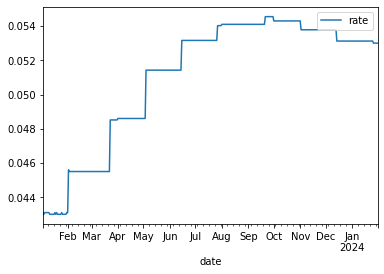

In [885]:
SOFR.bootstrap_from_futures(fomc_dates, futures_list)
SOFR.fill_curve_gaps()
SOFR.curve.plot()


In [844]:
prices_priced = [f.price_from_curve(SOFR) for f in futures_list]
pricing_error = np.array(prices) - np.array(prices_priced)


<AxesSubplot:title={'center':'Pricing replication'}>

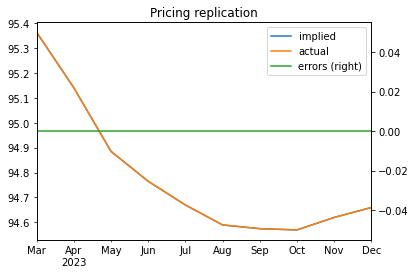

In [845]:
price_df = pd.DataFrame(
    index=pd.DatetimeIndex(dates),
    data={"implied": prices_priced, "actual": prices, "errors": pricing_error},
)
price_df.iloc[:-2].plot(title="Pricing replication", secondary_y=["errors"])


In [776]:
SOFR.curve.to_csv("output.csv")
